In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [16]:
#img = cv2.imread('Images/People.jpg',1)
#img = cv2.imread('Images/woman.jpeg',1)
#img = cv2.imread('Images/skin.jpeg',1)
#img = cv2.imread('Images/girl3.png',1)
#img = cv2.imread('Images/girl2.png',1)
img = cv2.imread('Images/mopi.jpeg')
imgInfo = img.shape
height = imgInfo[0]
width = imgInfo[1]
cv2.imshow('src',img)
cv2.waitKey(0)

13

In [17]:
# 线性动态调整
def Dynamic_adjust_liner(img,th1,th2):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    height = img.shape[0]
    width = img.shape[1]
    dst = img.copy()
    for i in range(0,height):
        for j in range(0,width):
                if(img[i,j]<th1):
                    dst[i,j]= 0
                elif(img[i,j]<th2):
                    dst[i,j]= 255/(th2-th1)*(img[i,j]-th1)
                elif(img[i,j]>=th2):
                     dst[i,j] = 255
    cv2.imshow('dst',dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return dst
#dst = Dynamic_adjust_liner(gray,100,150)

In [18]:
# 非线性调整

In [19]:
# 亮度增加
def lighten(img):
    dst = np.zeros([height,width,3],np.uint8)
    for i in range(0,height):
        for j in range(0,width):        
            (b,g,r) = img[i,j]
            bb = int(b) + 40           
            gg = int(g) + 40
            rr = int(r) + 40
            if bb > 255:
                bb = 255
            if gg > 255:
                gg = 255
            if rr > 255:
                rr = 255
            dst[i,j] = (bb,gg,rr)
    cv2.imshow('dst',dst)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return dst




In [20]:
# 肤色检测 基于YCrCb颜色空间的Cr分量+Otsu法阈值分割算法
def YCrCb_OTSU(img):
    start = time.time()
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  有没有转换公式呢？
    (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像

    # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
    cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # 对cr通道分量进行高斯滤波
    # 根据OTSU算法求图像阈值, 对图像进行二值化
    _, skin = cv2.threshold(cr1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    end = time.time()
    print("耗时"+str(end-start)+"秒")
    cv2.imshow("image CR", cr1)
    cv2.imshow("Skin Cr+OSTU", skin )
    cv2.waitKey(0)

YCrCb_OTSU(img)

耗时0.001870870590209961秒


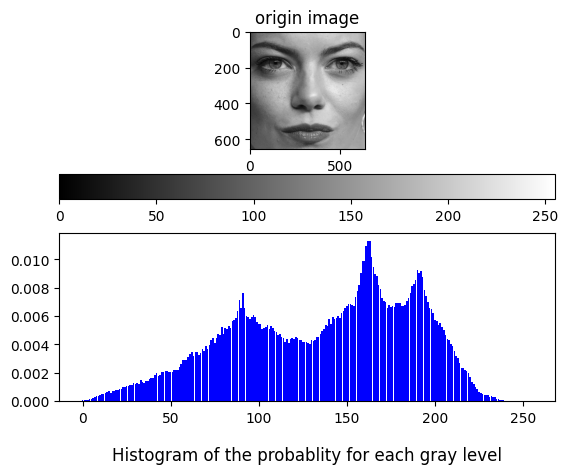

In [21]:
# 像素分布概率直方图
def showimg_pro_eachgray(img):                                          # 显示每一个灰度级的像素数概率
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                          # 灰度化处理
          
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])            # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                          # 获得每个灰度级中像素数占总像素数比例则我们获得了pi的一个向量
    x = np.linspace(0, 255, 256)                                        # 横坐标灰度级别
    plt.subplot(2,1,1)
    plt.imshow(img,'gray')                                              # 如果不加gray就会出现以前hsv与rgb的问题
    plt.title('origin image')
    plt.colorbar(orientation="horizontal")                              # 水平放置颜色条
    plt.subplot(2,1,2)
    plt.bar(x, p.ravel(), 0.9, alpha=1, color='b')
    plt.title('Histogram of the probablity for each gray level',y=-0.4) # 调节标题上下移动的方法
    plt.show()

showimg_pro_eachgray(img)


In [22]:
# 手撸实现OTSU
def OTSU(img):
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                             # 若待划分的图像是单通道，则无需转为灰度图
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    maxvar=0
    mG = np.sum(x*p)                                                        # 平均灰度级
    th=0
    step = 0
    for k1 in range(1,256):                                                 # 暴力搜索
        p1 = np.sum(p[0:k1])
        p2 = np.sum(p[k1:256])
        m1 = np.dot(x[0:k1],p[0:k1])/p1
        m2 = np.dot(x[k1:256],p[k1:256])/p2
        vars = p1*p2*(m1-m2)**2
        if(vars>maxvar):
            maxvar = vars
            th = k1
            step = step+1
            print("第"+str(step)+"次找到最佳阈值"+str(th)+","+"最大类间方差为"+str(maxvar))
    return th,maxvar 
print("最佳阈值是"+str(OTSU(img)[0]),"最大方差为"+str(OTSU(img)[1]))


第1次找到最佳阈值1,最大类间方差为[21.34327318]
第2次找到最佳阈值2,最大类间方差为[28.30587078]
第3次找到最佳阈值3,最大类间方差为[36.62671795]
第4次找到最佳阈值4,最大类间方差为[45.34115286]
第5次找到最佳阈值5,最大类间方差为[55.49908094]
第6次找到最佳阈值6,最大类间方差为[67.16649219]
第7次找到最佳阈值7,最大类间方差为[80.49920063]
第8次找到最佳阈值8,最大类间方差为[93.82641987]
第9次找到最佳阈值9,最大类间方差为[107.00602383]
第10次找到最佳阈值10,最大类间方差为[121.4569604]
第11次找到最佳阈值11,最大类间方差为[136.28095308]
第12次找到最佳阈值12,最大类间方差为[150.88035836]
第13次找到最佳阈值13,最大类间方差为[167.04259188]
第14次找到最佳阈值14,最大类间方差为[183.53299607]
第15次找到最佳阈值15,最大类间方差为[199.2577442]
第16次找到最佳阈值16,最大类间方差为[215.48736726]
第17次找到最佳阈值17,最大类间方差为[231.37632763]
第18次找到最佳阈值18,最大类间方差为[247.11876334]
第19次找到最佳阈值19,最大类间方差为[262.0335583]
第20次找到最佳阈值20,最大类间方差为[278.31622953]
第21次找到最佳阈值21,最大类间方差为[294.95376771]
第22次找到最佳阈值22,最大类间方差为[310.98453883]
第23次找到最佳阈值23,最大类间方差为[327.86328084]
第24次找到最佳阈值24,最大类间方差为[344.4434693]
第25次找到最佳阈值25,最大类间方差为[361.37719882]
第26次找到最佳阈值26,最大类间方差为[377.33156106]
第27次找到最佳阈值27,最大类间方差为[394.1914315]
第28次找到最佳阈值28,最大类间方差为[411.58589151]
第29次找到最佳阈值29,最大类间方差为[428.77768827]
第30次找到最佳阈值30,最大类

In [23]:
# 手撸实现最大类间类内方差比
def OTSU_IMPROVE(img):
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                          # 若待划分的图像是单通道，则无需转为灰度图
    pixels = cv2.calcHist([img], [0], None, [256], [0, 256])                # 计算每个灰度级中所含像素数，返回的是一个（256,1）的数组
    p = pixels / (img.shape[0] * img.shape[1])                              # 获得每个灰度级中像素数占总像素数比例则我们获得了p_i的一个向量
    x=np.linspace(1,256,256)                                                # 灰度级像素范围定义，若定义为0～255，则求平均灰度级时会忽略第一个数据，所以我们定义为从1到256                                                 
    sigma_b = 0                                                             # 类间方差
    sigma_in = 0                                                            # 类内方差
    maxvar = 0                                                              # 最大类间类内方差比
    mG = np.sum(x*p)                                                        # 平均灰度级
    th=0
    step = 0
    for k1 in range(1,256):                                                 # 暴力搜索
        p1 = np.sum(p[0:k1])
        p2 = np.sum(p[k1:256])
        m1 = np.dot(x[0:k1],p[0:k1])/p1
        m2 = np.dot(x[k1:256],p[k1:256])/p2
        vars1 = p1*p2*(m1-m2)**2
        if(vars1>sigma_b):
            sigma_b = vars1
        vars2 = np.sum(p[0:k1]*(x[0:k1]-m1)**2)+np.sum(p[k1:256]*(x[k1:256]-m2)**2)
        if(vars2>sigma_in):
            sigma_in = vars2
        if(sigma_in>0):
            vars = sigma_b/sigma_in
        else:
            vars = 0
        if(vars>maxvar):
            maxvar = vars
            th = k1
            step = step + 1
            print("第"+str(step)+"次找到最佳阈值"+str(th)+","+"最大类间方差为"+str(maxvar))
    return th,maxvar 
print("最佳阈值是"+str(OTSU_IMPROVE(img)[0]),"最大方差比为"+str(OTSU_IMPROVE(img)[1]))    

        
    
    



第1次找到最佳阈值1,最大类间方差为[1.40517372e-05]
第2次找到最佳阈值2,最大类间方差为[1.86356917e-05]
第3次找到最佳阈值3,最大类间方差为[2.41138748e-05]
第4次找到最佳阈值4,最大类间方差为[2.98511836e-05]
第5次找到最佳阈值5,最大类间方差为[3.65388427e-05]
第6次找到最佳阈值6,最大类间方差为[4.4220298e-05]
第7次找到最佳阈值7,最大类间方差为[5.29981323e-05]
第8次找到最佳阈值8,最大类间方差为[6.17723527e-05]
第9次找到最佳阈值9,最大类间方差为[7.04493878e-05]
第10次找到最佳阈值10,最大类间方差为[7.99634282e-05]
第11次找到最佳阈值11,最大类间方差为[8.9723077e-05]
第12次找到最佳阈值12,最大类间方差为[9.93348645e-05]
第13次找到最佳阈值13,最大类间方差为[0.00010998]
第14次找到最佳阈值14,最大类间方差为[0.00012083]
第15次找到最佳阈值15,最大类间方差为[0.00013119]
第16次找到最佳阈值16,最大类间方差为[0.00014187]
第17次找到最佳阈值17,最大类间方差为[0.00015233]
第18次找到最佳阈值18,最大类间方差为[0.0001627]
第19次找到最佳阈值19,最大类间方差为[0.00017251]
第20次找到最佳阈值20,最大类间方差为[0.00018323]
第21次找到最佳阈值21,最大类间方差为[0.00019419]
第22次找到最佳阈值22,最大类间方差为[0.00020474]
第23次找到最佳阈值23,最大类间方差为[0.00021585]
第24次找到最佳阈值24,最大类间方差为[0.00022677]
第25次找到最佳阈值25,最大类间方差为[0.00023792]
第26次找到最佳阈值26,最大类间方差为[0.00024842]
第27次找到最佳阈值27,最大类间方差为[0.00025952]
第28次找到最佳阈值28,最大类间方差为[0.00027098]
第29次找到最佳阈值29,最大类间方差为[0.00028229]
第30次找到最佳阈值30,最大类

In [24]:
# 基于手撸的OTSU_IMPROVE 实现的YCrCb分割                  # 凸显改进算法的优越性，使用mopi.jpeg例子，能良好体现出改进之后的算法，具有更强的识别效果，在处理肤色相近，像素值集中的图像时更占上风
def YCrCb_OTSU(img):ß
    start  = time.time()                               # 引入计时模块
    ycrcb = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)      #   RGB->YCrCb  有没有转换公式呢？
    (y,cr,cb) = cv2.split(ycrcb)                       # 图像分割，分别获取y,cr,br通道图像
    cr1 = cv2.GaussianBlur(cr, (5, 5), 0) # # 高斯滤波, cr 是待滤波的源图像数据, (5,5)是值窗口大小, 0 是指根据窗口大小来计算高斯函数标准差
    th = OTSU_IMPROVE(cr1)[0]
    skin = cr1.copy()
    # 根据OTSU算法求图像阈值, 对图像进行二值化 获得人脸部分（白色）,会发现因为手部与脸部肤色相近，故被认定为前景（人脸部分）
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if(cr1[i,j]< th):           
                skin[i,j]= 0  
            else:  
                skin[i,j] = 255

    # # 原图的人脸部分
    # for i in range(0,img.shape[ßß0]):
    #     for j in range(0,img.shape[1]): 
    #         if(skin[i,j]==0):
    #             img[i,j] = 0
    # cv2.imshow("SKin",img)
    end = time.time()
    print("耗时"+str(end-start)+"s")
    # 显示图像
    cv2.imshow("Skin Cr+OSTU_IMPROVE_Hand", skin) # 因为通过对YCrCb空间分割再还原RGB比较麻烦
    cv2.waitKey(0)
    cv2.destroyAllWindows()


YCrCb_OTSU(img)

第1次找到最佳阈值108,最大类间方差为[1.29962958e-08]
第2次找到最佳阈值109,最大类间方差为[7.5183622e-08]
第3次找到最佳阈值110,最大类间方差为[4.20059591e-07]
第4次找到最佳阈值111,最大类间方差为[3.36410034e-06]
第5次找到最佳阈值112,最大类间方差为[1.12556748e-05]
第6次找到最佳阈值113,最大类间方差为[3.00777251e-05]
第7次找到最佳阈值114,最大类间方差为[4.4292186e-05]
第8次找到最佳阈值115,最大类间方差为[5.04860331e-05]
第9次找到最佳阈值116,最大类间方差为[5.86697478e-05]
第10次找到最佳阈值117,最大类间方差为[6.08063798e-05]
第11次找到最佳阈值118,最大类间方差为[6.18386528e-05]
第12次找到最佳阈值119,最大类间方差为[6.2663622e-05]
第13次找到最佳阈值120,最大类间方差为[6.3736589e-05]
第14次找到最佳阈值121,最大类间方差为[6.59154782e-05]
第15次找到最佳阈值122,最大类间方差为[6.81280538e-05]
第16次找到最佳阈值123,最大类间方差为[7.26543978e-05]
第17次找到最佳阈值124,最大类间方差为[7.6002218e-05]
第18次找到最佳阈值125,最大类间方差为[7.90554442e-05]
第19次找到最佳阈值126,最大类间方差为[8.32245992e-05]
第20次找到最佳阈值127,最大类间方差为[8.72074873e-05]
第21次找到最佳阈值128,最大类间方差为[9.23923967e-05]
第22次找到最佳阈值129,最大类间方差为[9.95736695e-05]
第23次找到最佳阈值130,最大类间方差为[0.00010642]
第24次找到最佳阈值131,最大类间方差为[0.00011044]
第25次找到最佳阈值132,最大类间方差为[0.00011333]
第26次找到最佳阈值133,最大类间方差为[0.00011599]
第27次找到最佳阈值134,最大类间方差为[0.00011982]
第28次找到最佳

/var/folders/l9/f9rjm65s07bdf55y5xyk9f2c0000gn/T/ipykernel_23555/3248860860.py:16: RuntimeWarning: invalid value encountered in divide
  m1 = np.dot(x[0:k1],p[0:k1])/p1
/var/folders/l9/f9rjm65s07bdf55y5xyk9f2c0000gn/T/ipykernel_23555/3248860860.py:17: RuntimeWarning: invalid value encountered in divide
  m2 = np.dot(x[k1:256],p[k1:256])/p2


耗时0.36638593673706055s


In [25]:
# 二次多项式模式检测
def Quad_poly(img):
    Info = img.shape
    height = Info[0]
    width = Info[1]
    Channels = Info[2]
    # 创建一个与原图像大小相同的零数组
    skin = np.zeros((height,width),np.uint8)
    for i in range(0,height):
        for j in range(0,width):
            B = img[i,j,0]
            G = img[i,j,1]
            R = img[i,j,2]
            if(R-G>=20):
                if(G>B):
                    sum = R+G+B
                    t1 = 100*R-33*sum
                    t2 = 100*G-33*sum
                    if((t1**2+t2**2)>=4*sum*sum):
                        T1 = 10000*G*sum
                        lower = -7760*R**2 + 5601*R*sum + 1766*sum**2
                        if(T1>lower):
                            upper = -13767*R**2 + 10743*R*sum + 1452*sum**2
                            if(T1<upper):
                                skin[i,j] = 255
    cv2.imshow('skin2',skin)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return skin
skin = Quad_poly(img)
# 效果垃圾 笑果还行     人脸面部会反光，导致反光区域的RGB值偏高，会被筛选出人脸区域，而人脸轮廓例如脸颊、腮部亮度比较稳定，会被识别为人脸区域


/var/folders/l9/f9rjm65s07bdf55y5xyk9f2c0000gn/T/ipykernel_23555/2248324870.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  sum = R+G+B
/var/folders/l9/f9rjm65s07bdf55y5xyk9f2c0000gn/T/ipykernel_23555/2248324870.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  if(R-G>=20):


In [26]:
# 基于HSV颜色空间H，S，V范围筛选法
def HSV(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # 把图像转换到HSV色域
    (h, s, v) = cv2.split(hsv) # 图像分割, 分别获取h, s, v 通道分量图像
    skin = np.zeros(h.shape, np.uint8)  # 根据源图像的大小创建一个全0的矩阵,用于保存图像数据
    (height, width) = img.shape[0:2] # 获取源图像数据的长和宽

    # 遍历图像, 判断HSV通道的数值, 如果在指定范围中, 则置把新图像的点设为255,否则设为0
    for i in  range(0, height):
        for j in  range(0, width):
            if (h[i][j] >  2) and (h[i][j] <  15) and (s[i][j] >  35) and (s[i][j] <  255) and (v[i][j] >  60) and (v[i][j] <  255):
                skin[i][j] =  255
            else:
                skin[i][j] =  0
    cv2.imshow('skin',skin)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return skin

# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # 把图像转换到HSV色域
# cv2.imshow('hsv',hsv)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
#HSV(img)
    


In [27]:
# 双边滤波
dst1 = cv2.bilateralFilter(img,15,35,35) # 邻域半径为15 sigma_d为空间高斯函数标准差，sigma_r为灰度值相似性高斯函数标准差
#cv2.imshow('dst1',dst1)


In [28]:
# 磨皮算法 
# 通过上述算法获得皮肤区域，遍历双边滤波后的矩阵，将非皮肤区域还原
def skin_(dst1,img,skin1):       #dst1 为双边滤波后的矩阵  img 为原图 skin1 为皮肤区域
    dst2 = dst1.copy()
    for i in range(0,height):   
        for j in range(0,width):
            if(skin1[i,j] == 0):
                dst2[i,j] = img[i,j]

    cv2.imshow('dst2',dst2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()